In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

`torchvision`의 `Image Transform` 에 대하여 생소하다면 **다음의 링크를 참고**해 주시기 바랍니다.

- [torchvision의 transform으로 이미지 정규화하기(평균, 표준편차를 계산하여 적용](https://teddylee777.github.io/pytorch/torchvision-transform)
- [PyTorch 이미지 데이터셋(Image Dataset) 구성에 관한 거의 모든 것!](https://teddylee777.github.io/pytorch/dataset-dataloader)


`rps` 데이터셋을 다운로드 받아서 `tmp` 폴더에 압축을 풀어 줍니다.

- `rps` 데이터셋은 **가위바위보 이미지 데이터셋** 입니다.


In [2]:
# 이미지 데이터셋 다운로드
import urllib.request
import zipfile

# 데이터셋을 다운로드 합니다.
# 다운로드 후 tmp 폴더에 압축을 해제 합니다.
url = "https://storage.googleapis.com/download.tensorflow.org/data/rps.zip"
urllib.request.urlretrieve(url, "rps.zip")
local_zip = "rps.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("tmp/")
zip_ref.close()

`rps` 데이터셋을 시각화 하기 위하여 임시 `DataLoader`를 생성합니다.


In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


# 이미지 폴더로부터 데이터를 로드합니다.
dataset = ImageFolder(
    root="tmp/rps",  # 다운로드 받은 폴더의 root 경로를 지정합니다.
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    ),
)

data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)

In [4]:
# ImageFolder로부터 로드한 dataset의 클래스를 확인합니다.
# 총 3개의 클래스로 구성되었음을 확인할 수 있습니다(paper, rock, scissors)
dataset.classes

['paper', 'rock', 'scissors']

In [5]:
# 1개의 배치를 추출합니다.
images, labels = next(iter(data_loader))

In [6]:
# 이미지의 shape을 확인합니다. 300 X 300 RGB 이미지 임을 확인합니다.
images[0].shape

torch.Size([3, 300, 300])

`rps` 데이터셋 시각화

- 총 3개의 class(가위/바위/보)로 구성된 사진 파일입니다.
- 출처: [Laurence Moroney Dataset](http://laurencemoroney.com/rock-paper-scissors-dataset)


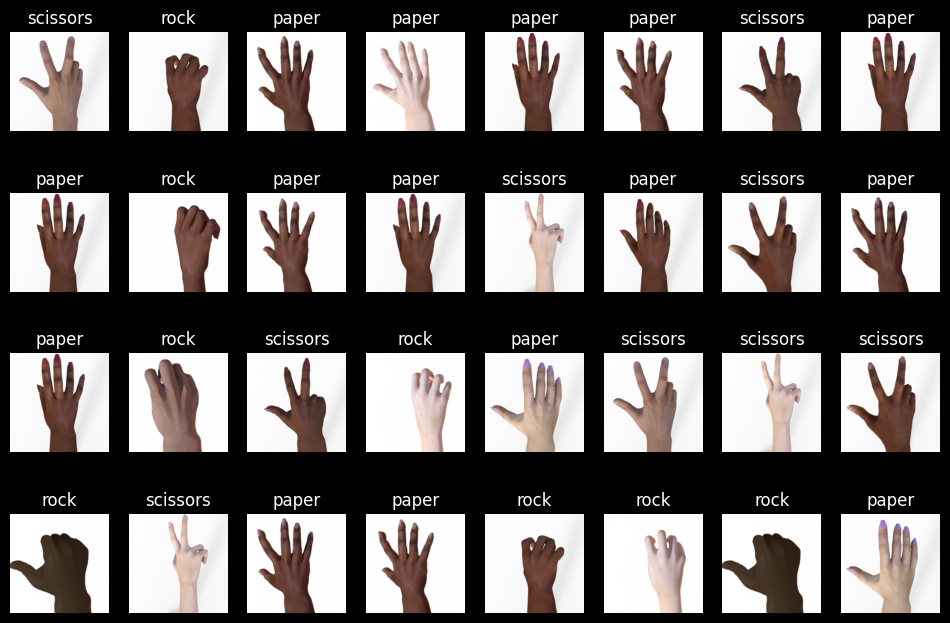

In [7]:
import matplotlib.pyplot as plt

# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v: k for k, v in dataset.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 4

# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # 본래 이미지의 shape은 (3, 300, 300) 입니다.
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (300, 300, 3)으로 shape 변경을 한 후 시각화합니다.
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

## Image Augmentation 적용


`Image Augmentation`을 적용 합니다.

- [PyTorch Image Augmentation 도큐먼트](https://pytorch.org/vision/stable/transforms.html)


In [8]:
# Image Transform을 지정합니다.
image_transform = transforms.Compose(
    [
        # Resize (300 X 300) -> (224, 224) 크기 조정
        transforms.Resize(size=(224, 224)),
        transforms.RandomHorizontalFlip(0.5),  # 50% 확률로 Horizontal Flip
        transforms.ToTensor(),  # Tensor 변환 (정규화)
        #     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [9]:
# 이미지 폴더로부터 데이터를 로드합니다.
dataset = ImageFolder(
    root="tmp/rps",  # 다운로드 받은 폴더의 root 경로를 지정합니다.
    transform=image_transform,
)  # Image Augmentation 적용

In [10]:
# Image Augmentation 이 적용된 DataLoader를 로드 합니다.
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)

# 1개의 배치를 추출합니다.
images, labels = next(iter(data_loader))

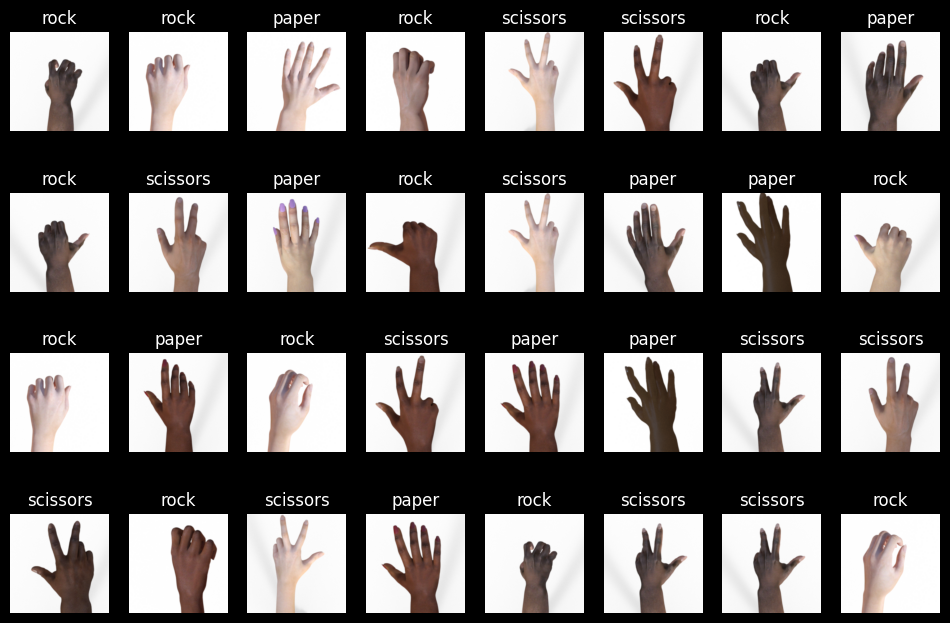

In [11]:
# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v: k for k, v in dataset.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 4

# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # 본래 이미지의 shape은 (3, 300, 300) 입니다.
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (300, 300, 3)으로 shape 변경을 한 후 시각화합니다.
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

## train / validation 데이터셋 split


현재 `rps`에 하나의 데이터셋으로 구성된 Image 파일을 2개의 데이터셋(train/test)으로 분할하도록 하겠습니다.


In [12]:
from torch.utils.data import random_split


ratio = 0.8  # 학습셋(train set)의 비율을 설정합니다.

train_size = int(ratio * len(dataset))
test_size = len(dataset) - train_size
print(f"total: {len(dataset)}\ntrain_size: {train_size}\ntest_size: {test_size}")

# random_split으로 8:2의 비율로 train / test 세트를 분할합니다.
train_data, test_data = random_split(dataset, [train_size, test_size])

total: 2520
train_size: 2016
test_size: 504


## torch.utils.data.DataLoader

`DataLoader`는 배치 구성과 shuffle등을 편하게 구성해 주는 util 입니다.


In [13]:
batch_size = 32  # batch_size 지정
num_workers = 8  # Thread 숫자 지정 (병렬 처리에 활용할 쓰레드 숫자 지정)

train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
test_loader = DataLoader(
    test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

`train_loader`의 1개 배치의 shape 출력


In [14]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

배치사이즈인 32가 가장 첫번째 dimension에 출력되고, 그 뒤로 채널(3), 세로(224px), 가로(224px) 순서로 출력이 됩니다.

즉, `224 X 224` RGB 컬러 이미지 `32장`이 1개의 배치로 구성이 되어 있습니다.


In [15]:
# 1개의 이미지의 shape를 확인합니다.
# 224 X 224 RGB 이미지가 잘 로드 되었음을 확인합니다.
images[0].shape

torch.Size([3, 224, 224])

## 모델 정의


CUDA 설정이 되어 있다면 `cuda`를! 그렇지 않다면 `cpu`로 학습합니다.

(제 PC에는 GPU가 2대 있어서 `cuda:0`로 GPU 장비의 index를 지정해 주었습니다. 만약 다른 장비를 사용하고 싶다면 `cuda:1` 이런식으로 지정해 주면 됩니다)


In [48]:
# CUDA 사용 가능 여부 확인
if torch.backends.mps.is_built():
    # mac os mps 지원 체크
    device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
else:
    # cuda 사용 가능한지 체크
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


아래의 모델은 DNN으로 구성하였습니다. 추후, 모델 부분을 CNN이나 pre-trained model로 교체할 수 있습니다.

[참고]

- http://layer-calc.com/


In [49]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Linear(7 * 7 * 128, 3)

    def forward(self, x):
        x = self.sequential(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [50]:
model = CNNModel()  # Model 생성

`torchsummary`의 `summary`로 `CNNModel`의 구조와 paramter 수를 요약 출력 합니다.

- 설치되어 있지 않다면 `pip install torchsummary`로 설치할 수 있습니다.


In [25]:
!pip install torchsummary -q

In [51]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          36,928
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]          73,856
             ReLU-11          [-1, 128, 28, 28]               0
        MaxPool2d-12          [-1, 128, 14, 14]               0
           Conv2d-13          [-1, 128, 14, 14]         147,584
             ReLU-14          [-1, 128,

In [52]:
# device 에 로드 (cpu or cuda)
model = model.to(device)

In [53]:
# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

## 훈련(Train) & 평가(Evaluate)


In [54]:
def fit(model, data_loader, loss_fn, optimizer, device, mode="train"):
    if mode == "train":
        # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
        model.train()
    else:
        # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다.
        model.eval()

    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    # prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for img, lbl in data_loader:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)
        optimizer.zero_grad()

        # 누적 Gradient를 초기화 합니다.
        with torch.set_grad_enabled(mode == "train"):
            # Forward Propagation을 진행하여 결과를 얻습니다.
            output = model(img)

            # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
            loss = loss_fn(output, lbl)

            if mode == "train":
                # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
                loss.backward()

                # 계산된 Gradient를 업데이트 합니다.
                optimizer.step()

        # output 의 뉴런별 확률 값을 sparse vector 로 변환합니다.
        pred = output.argmax(axis=1)

        # 정답 개수를 카운트 합니다.
        corr += (lbl == pred).sum().item()

        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item()

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)

    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader), acc

## 모델 훈련(training) & 검증


In [ ]:
import time

# 최대 Epoch을 지정합니다.
num_epochs = 10

min_loss = np.inf

STATE_DICT_PATH = "CNNModel.pth"

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    start = time.time()
    train_loss, train_acc = fit(
        model, train_loader, loss_fn, optimizer, device, mode="train"
    )

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = fit(model, test_loader, loss_fn, optimizer, device, mode="eval")

    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(
            f"[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!"
        )
        min_loss = val_loss
        torch.save(model.state_dict(), STATE_DICT_PATH)

    time_elapsed = time.time() - start
    # Epoch 별 결과를 출력합니다.
    print(
        f"epoch {epoch+1:02d}, duration: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}"
    )

## 저장한 가중치 로드 후 검증 성능 측정


In [ ]:
# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load(STATE_DICT_PATH))

In [ ]:
# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc = fit(model, test_loader, loss_fn, device)
print(
    f"evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}")